<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/hybrid_models_enconders_layering_w3_ST-HybridWaveStack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2025-05-22 13:34:27,577 - INFO - Ejecutando en Colab: False
2025-05-22 13:34:27,578 - INFO - Ejecutando en local. Base path: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction
2025-05-22 13:34:27,579 - INFO - Archivo encontrado: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
2025-05-22 13:34:27,580 - INFO - Archivo encontrado: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/features_fusion_branches.nc
2025-05-22 13:34:27,580 - INFO - Archivo encontrado: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/input/shapes/MGN_Departamento.shp
2025-05-22 13:34:27,581 - INFO - Usando dispositivo: cpu
2025-05-22 13:34:27,627 - INFO - Dataset completo cargado: /Users/riperez/Conda/anaconda3/envs/

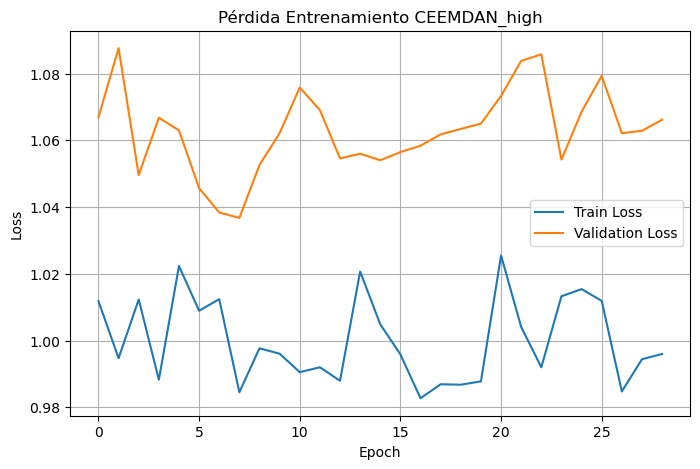

2025-05-22 13:35:53,456 - INFO - Procesando CEEMDAN_medium
/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-05-22 13:35:57,370 - INFO - [Base] Epoch 1/100 - Train Loss: 1.0163 - Val Loss: 1.0895
2025-05-22 13:35:59,852 - INFO - [Base] Epoch 2/100 - Train Loss: 1.0189 - Val Loss: 1.1764
2025-05-22 13:36:02,348 - INFO - [Base] Epoch 3/100 - Train Loss: 0.9898 - Val Loss: 1.1130
2025-05-22 13:36:04,782 - INFO - [Base] Epoch 4/100 - Train Loss: 0.9844 - Val Loss: 1.1284
2025-05-22 13:36:07,294 - INFO - [Base] Epoch 5/100 - Train Loss: 1.0117 - Val Loss: 1.1167
2025-05-22 13:36:09,847 - INFO - [Base] Epoch 6/100 - Train Loss: 1.0019 - Val Loss: 1.1336
2025-05-22 13:36:12,283 - INFO - [Base] Epoch 7/100 - Train

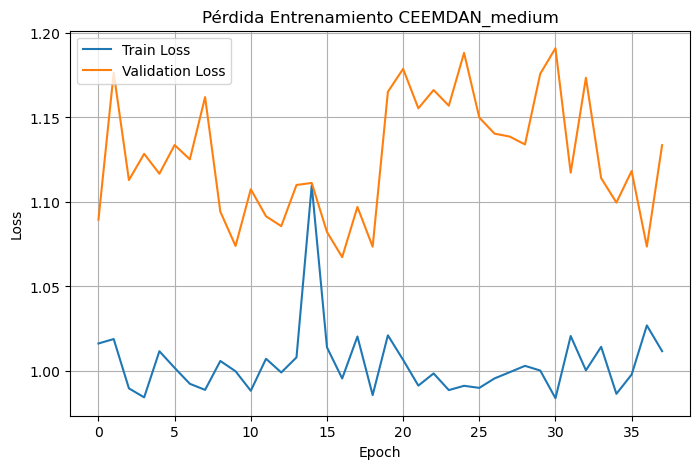

2025-05-22 13:37:39,340 - INFO - Procesando CEEMDAN_low
2025-05-22 13:37:53,520 - INFO - [Base] Epoch 1/100 - Train Loss: 0.7764 - Val Loss: 0.7019
2025-05-22 13:37:56,302 - INFO - [Base] Epoch 2/100 - Train Loss: 0.5212 - Val Loss: 0.5418
2025-05-22 13:37:58,841 - INFO - [Base] Epoch 3/100 - Train Loss: 0.4107 - Val Loss: 0.4194
2025-05-22 13:38:01,404 - INFO - [Base] Epoch 4/100 - Train Loss: 0.3675 - Val Loss: 0.3867
2025-05-22 13:38:03,861 - INFO - [Base] Epoch 5/100 - Train Loss: 0.3495 - Val Loss: 0.4527
2025-05-22 13:38:06,245 - INFO - [Base] Epoch 6/100 - Train Loss: 0.3536 - Val Loss: 0.4422
2025-05-22 13:38:08,733 - INFO - [Base] Epoch 7/100 - Train Loss: 0.3342 - Val Loss: 0.4349
2025-05-22 13:38:11,097 - INFO - [Base] Epoch 8/100 - Train Loss: 0.3328 - Val Loss: 0.3765
2025-05-22 13:38:14,035 - INFO - [Base] Epoch 9/100 - Train Loss: 0.3412 - Val Loss: 0.4315
2025-05-22 13:38:17,194 - INFO - [Base] Epoch 10/100 - Train Loss: 0.3276 - Val Loss: 0.3815
2025-05-22 13:38:19,933

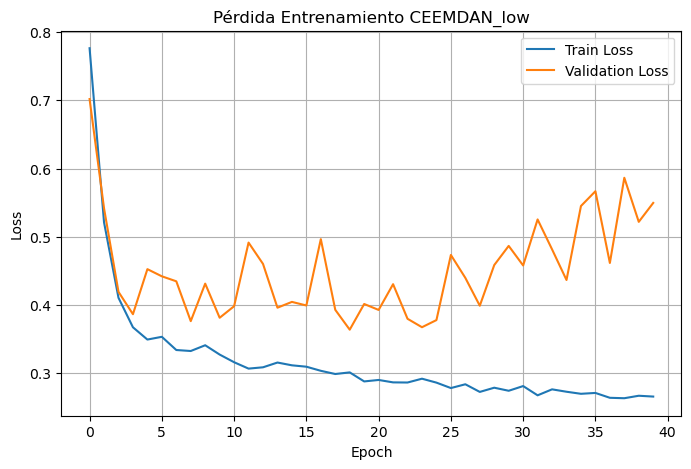

2025-05-22 13:39:45,465 - INFO - Procesando TVFEMD_high
/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-05-22 13:39:49,409 - INFO - [Base] Epoch 1/100 - Train Loss: 1.0100 - Val Loss: 1.0868
2025-05-22 13:39:51,887 - INFO - [Base] Epoch 2/100 - Train Loss: 1.0074 - Val Loss: 1.0593
2025-05-22 13:39:54,509 - INFO - [Base] Epoch 3/100 - Train Loss: 0.9934 - Val Loss: 1.0914
2025-05-22 13:39:57,049 - INFO - [Base] Epoch 4/100 - Train Loss: 1.0085 - Val Loss: 1.0623
2025-05-22 13:39:59,571 - INFO - [Base] Epoch 5/100 - Train Loss: 1.0017 - Val Loss: 1.0101
2025-05-22 13:40:02,200 - INFO - [Base] Epoch 6/100 - Train Loss: 0.9916 - Val Loss: 1.0689
2025-05-22 13:40:04,874 - INFO - [Base] Epoch 7/100 - Train Lo

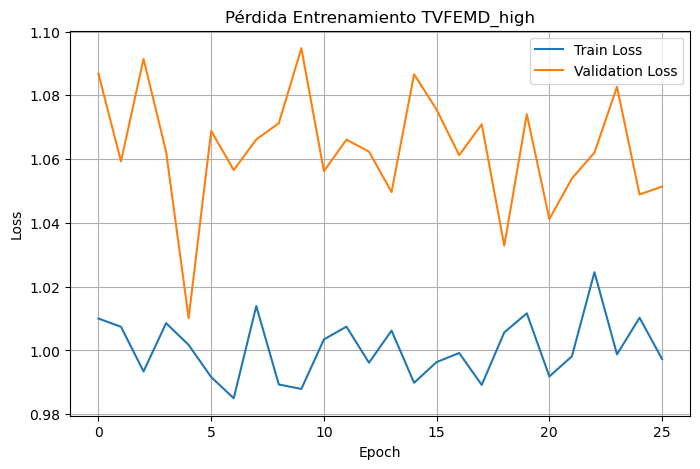

2025-05-22 13:40:56,341 - INFO - Procesando TVFEMD_medium
/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-05-22 13:41:00,173 - INFO - [Base] Epoch 1/100 - Train Loss: 1.0230 - Val Loss: 1.0832
2025-05-22 13:41:02,732 - INFO - [Base] Epoch 2/100 - Train Loss: 1.0059 - Val Loss: 1.0564
2025-05-22 13:41:05,257 - INFO - [Base] Epoch 3/100 - Train Loss: 0.9908 - Val Loss: 1.0643
2025-05-22 13:41:07,800 - INFO - [Base] Epoch 4/100 - Train Loss: 0.9935 - Val Loss: 1.0479
2025-05-22 13:41:10,323 - INFO - [Base] Epoch 5/100 - Train Loss: 1.0063 - Val Loss: 1.0928
2025-05-22 13:41:12,836 - INFO - [Base] Epoch 6/100 - Train Loss: 1.0146 - Val Loss: 1.0898
2025-05-22 13:41:15,418 - INFO - [Base] Epoch 7/100 - Train 

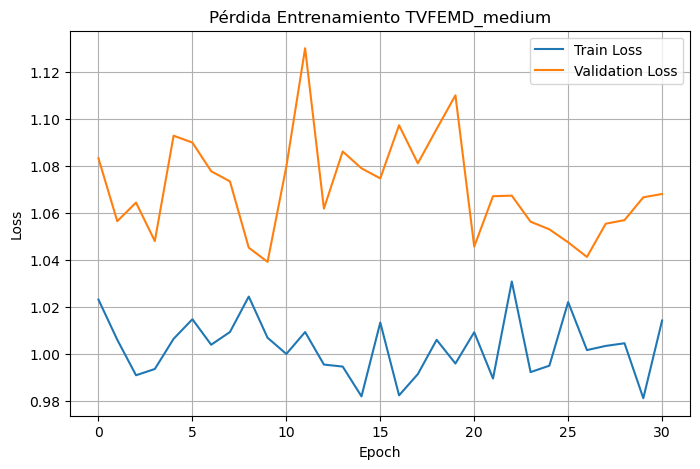

2025-05-22 13:42:19,659 - INFO - Procesando TVFEMD_low
2025-05-22 13:42:32,801 - INFO - [Base] Epoch 1/100 - Train Loss: 0.7775 - Val Loss: 0.7583
2025-05-22 13:42:35,567 - INFO - [Base] Epoch 2/100 - Train Loss: 0.5273 - Val Loss: 0.5174
2025-05-22 13:42:38,760 - INFO - [Base] Epoch 3/100 - Train Loss: 0.4194 - Val Loss: 0.4008
2025-05-22 13:42:41,384 - INFO - [Base] Epoch 4/100 - Train Loss: 0.3827 - Val Loss: 0.4548
2025-05-22 13:42:43,882 - INFO - [Base] Epoch 5/100 - Train Loss: 0.3603 - Val Loss: 0.3948
2025-05-22 13:42:47,045 - INFO - [Base] Epoch 6/100 - Train Loss: 0.3589 - Val Loss: 0.4141
2025-05-22 13:42:49,745 - INFO - [Base] Epoch 7/100 - Train Loss: 0.3381 - Val Loss: 0.3915
2025-05-22 13:42:52,444 - INFO - [Base] Epoch 8/100 - Train Loss: 0.3312 - Val Loss: 0.3769
2025-05-22 13:42:55,172 - INFO - [Base] Epoch 9/100 - Train Loss: 0.3346 - Val Loss: 0.3562
2025-05-22 13:42:57,619 - INFO - [Base] Epoch 10/100 - Train Loss: 0.3278 - Val Loss: 0.3936
2025-05-22 13:43:00,231 

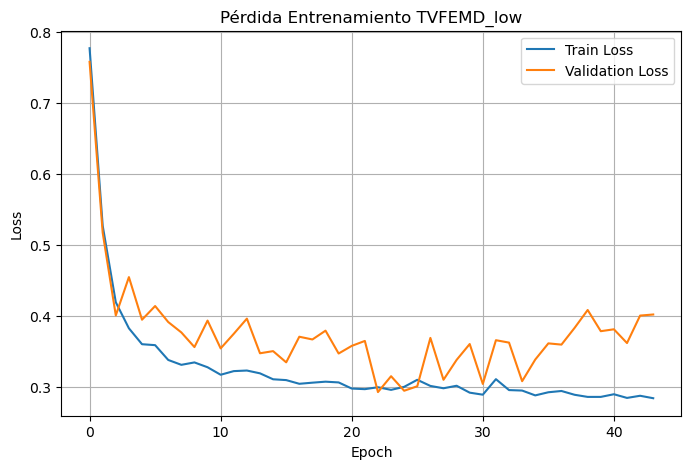

2025-05-22 13:44:28,614 - INFO - Procesando FUSION_high
/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-05-22 13:44:32,376 - INFO - [Base] Epoch 1/100 - Train Loss: 1.0172 - Val Loss: 1.0663
2025-05-22 13:44:34,856 - INFO - [Base] Epoch 2/100 - Train Loss: 1.0166 - Val Loss: 1.1088
2025-05-22 13:44:37,314 - INFO - [Base] Epoch 3/100 - Train Loss: 1.0003 - Val Loss: 1.0887
2025-05-22 13:44:39,870 - INFO - [Base] Epoch 4/100 - Train Loss: 1.0158 - Val Loss: 1.0880
2025-05-22 13:44:42,430 - INFO - [Base] Epoch 5/100 - Train Loss: 1.0194 - Val Loss: 1.0732
2025-05-22 13:44:45,052 - INFO - [Base] Epoch 6/100 - Train Loss: 0.9922 - Val Loss: 1.0706
2025-05-22 13:44:47,549 - INFO - [Base] Epoch 7/100 - Train Lo

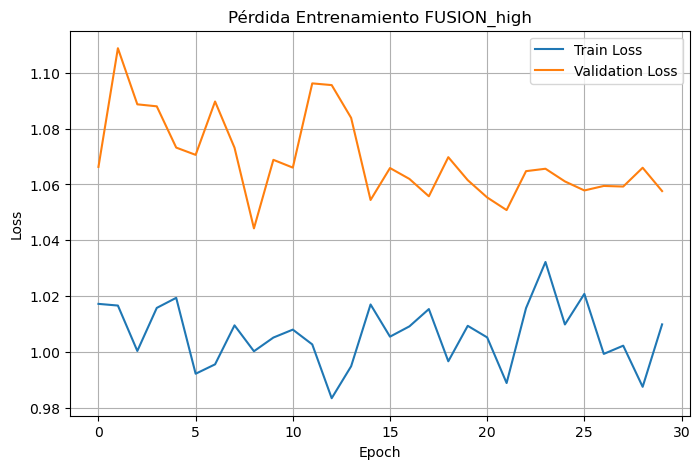

2025-05-22 13:45:48,832 - INFO - Procesando FUSION_medium
/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-05-22 13:45:52,104 - INFO - [Base] Epoch 1/100 - Train Loss: 0.9998 - Val Loss: 1.1165
2025-05-22 13:45:54,505 - INFO - [Base] Epoch 2/100 - Train Loss: 1.0337 - Val Loss: 1.0808
2025-05-22 13:45:56,930 - INFO - [Base] Epoch 3/100 - Train Loss: 1.0020 - Val Loss: 1.0812
2025-05-22 13:45:59,348 - INFO - [Base] Epoch 4/100 - Train Loss: 0.9823 - Val Loss: 1.0564
2025-05-22 13:46:01,847 - INFO - [Base] Epoch 5/100 - Train Loss: 0.9999 - Val Loss: 1.0899
2025-05-22 13:46:04,208 - INFO - [Base] Epoch 6/100 - Train Loss: 0.9955 - Val Loss: 1.0499
2025-05-22 13:46:06,571 - INFO - [Base] Epoch 7/100 - Train 

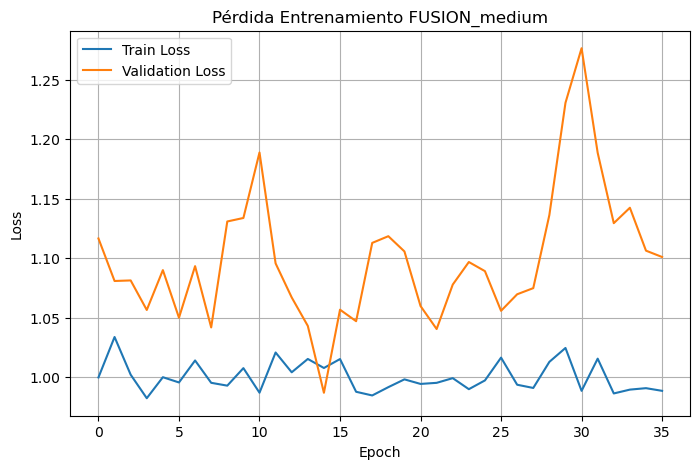

2025-05-22 13:47:22,605 - INFO - Procesando FUSION_low
2025-05-22 13:47:35,223 - INFO - [Base] Epoch 1/100 - Train Loss: 0.7758 - Val Loss: 0.7328
2025-05-22 13:47:37,856 - INFO - [Base] Epoch 2/100 - Train Loss: 0.5206 - Val Loss: 0.4956
2025-05-22 13:47:40,316 - INFO - [Base] Epoch 3/100 - Train Loss: 0.4075 - Val Loss: 0.3953
2025-05-22 13:47:42,716 - INFO - [Base] Epoch 4/100 - Train Loss: 0.3729 - Val Loss: 0.3712
2025-05-22 13:47:45,841 - INFO - [Base] Epoch 5/100 - Train Loss: 0.3566 - Val Loss: 0.3482
2025-05-22 13:47:49,423 - INFO - [Base] Epoch 6/100 - Train Loss: 0.3499 - Val Loss: 0.3947
2025-05-22 13:47:52,365 - INFO - [Base] Epoch 7/100 - Train Loss: 0.3402 - Val Loss: 0.4132
2025-05-22 13:47:55,801 - INFO - [Base] Epoch 8/100 - Train Loss: 0.3222 - Val Loss: 0.5658
2025-05-22 13:47:58,614 - INFO - [Base] Epoch 9/100 - Train Loss: 0.3274 - Val Loss: 0.4803
2025-05-22 13:48:01,299 - INFO - [Base] Epoch 10/100 - Train Loss: 0.3168 - Val Loss: 0.4458
2025-05-22 13:48:03,838 

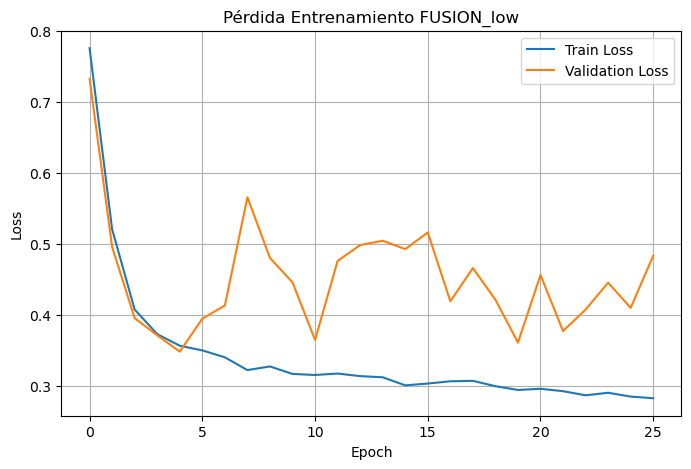

2025-05-22 13:48:41,798 - INFO - Meta dataset preparado: Xm (3, 9, 61, 65, 1), ym (3, 61, 65, 1)
2025-05-22 13:48:41,840 - INFO - Forma de entrada Xb: torch.Size([2, 9, 61, 65, 1])
2025-05-22 13:48:41,841 - INFO - Forma de objetivo yb: torch.Size([2, 61, 65, 1])
2025-05-22 13:48:41,842 - INFO - Ajustando horizonte de salida objetivo a 61 (configurado: 3)
2025-05-22 13:48:42,148 - WARNING - Ajuste de compatibilidad: cambiando horizonte de 61 a 3
2025-05-22 13:48:42,149 - INFO - Adaptando dimensión 2: 61 → 65
2025-05-22 13:48:42,150 - INFO - Adaptando dimensión 3: 65 → 1
2025-05-22 13:48:42,151 - INFO - Forma inicial de salida del modelo: torch.Size([2, 3, 65, 1])
2025-05-22 13:48:42,151 - WARNING - Desajuste de forma - output: torch.Size([2, 3, 65, 1]), yb: torch.Size([2, 61, 65, 1])
2025-05-22 13:48:42,789 - INFO - Ajustando horizonte de salida objetivo a 61 (configurado: 3)
2025-05-22 13:48:42,896 - WARNING - Ajuste de compatibilidad: cambiando horizonte de 61 a 3
2025-05-22 13:48:42,

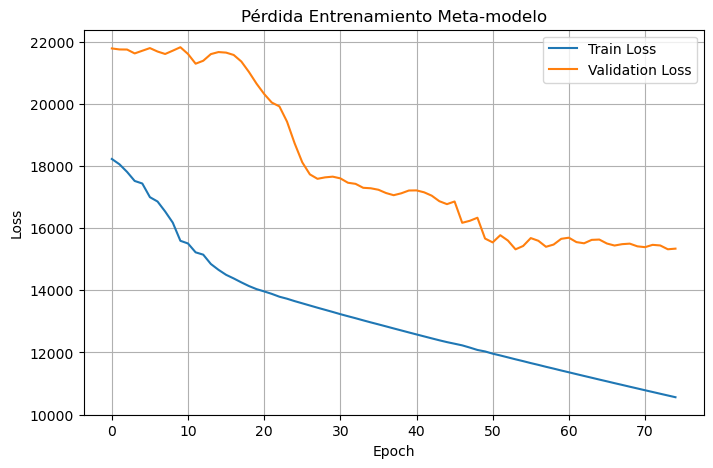

2025-05-22 13:49:55,815 - INFO - Meta-modelo entrenado y guardado.
2025-05-22 13:49:55,817 - INFO - Ajustando horizonte de salida objetivo a 61 (configurado: 3)
2025-05-22 13:49:55,919 - WARNING - Ajuste de compatibilidad: cambiando horizonte de 61 a 3
2025-05-22 13:49:55,919 - INFO - Adaptando dimensión 2: 61 → 65
2025-05-22 13:49:55,920 - INFO - Adaptando dimensión 3: 65 → 1
2025-05-22 13:49:55,920 - INFO - Forma final de salida: torch.Size([1, 3, 65, 1])
2025-05-22 13:49:55,922 - INFO - Meta-model Metrics: RMSE=103.311, MAE=91.547, MAPE=82.090%, R2=-4.668
2025-05-22 13:49:55,947 - INFO - Métricas meta-modelo guardadas en /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/metrics_meta_ref2025-02.csv


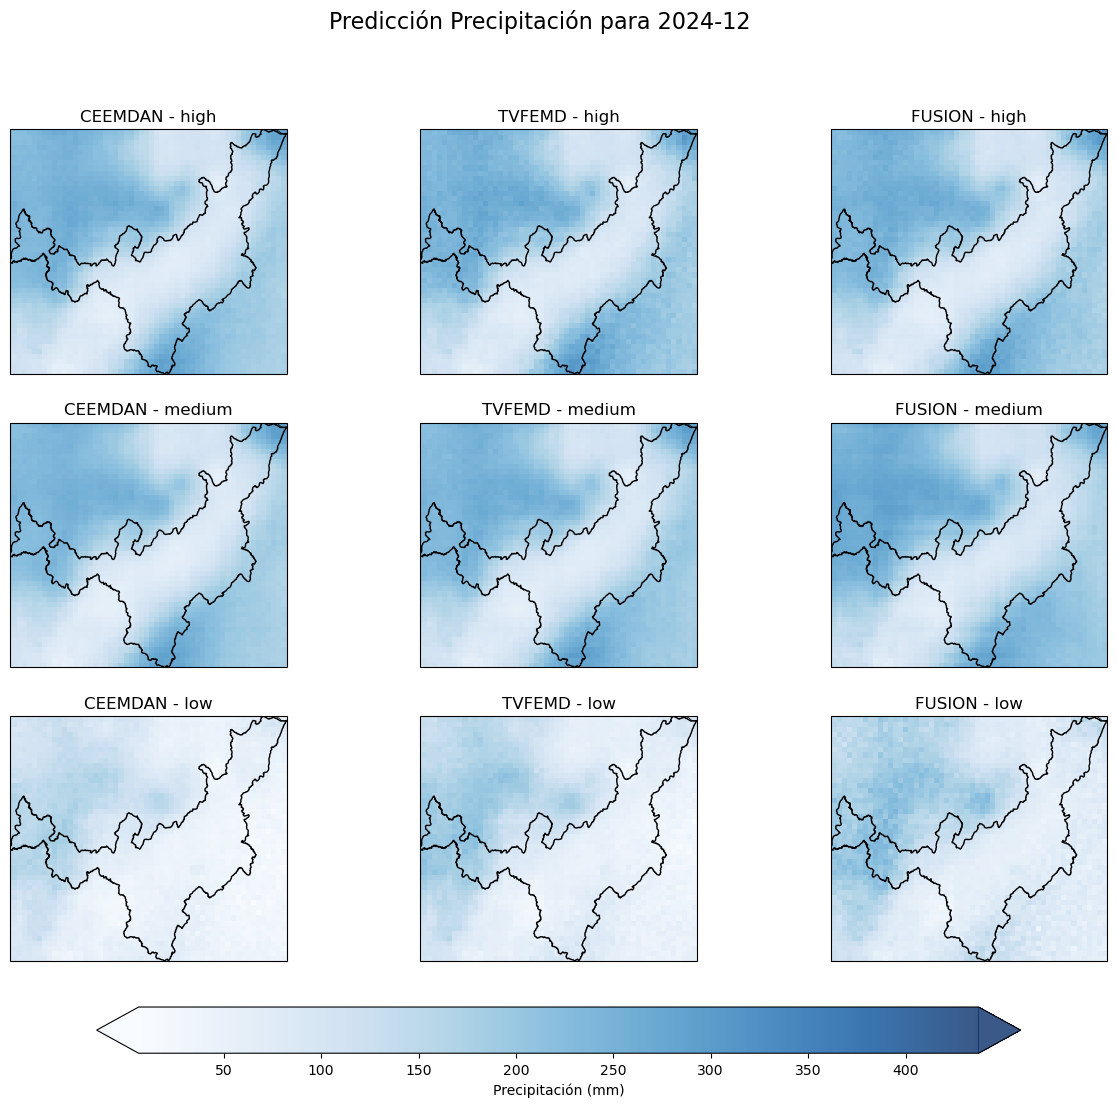

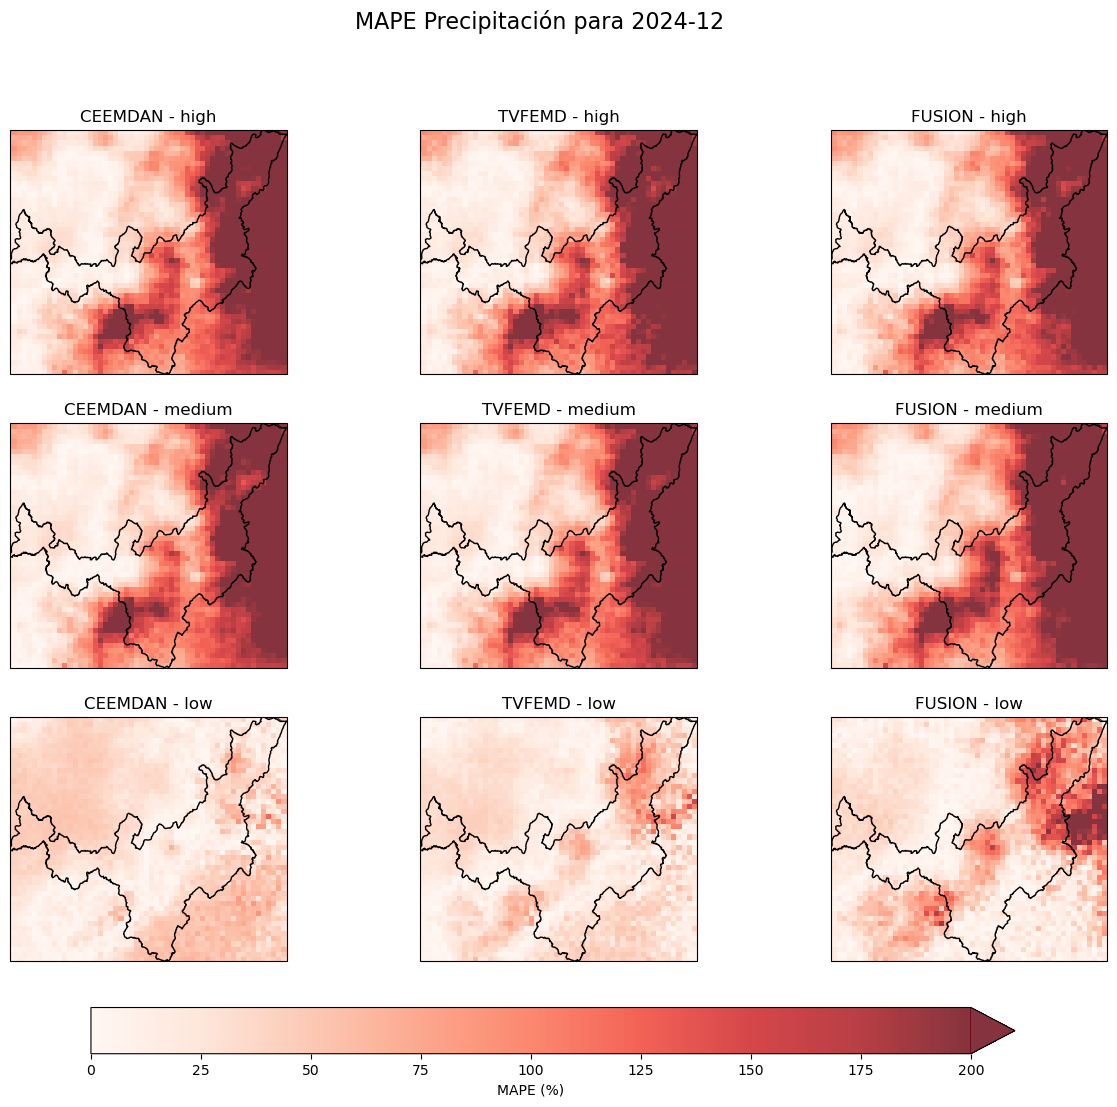

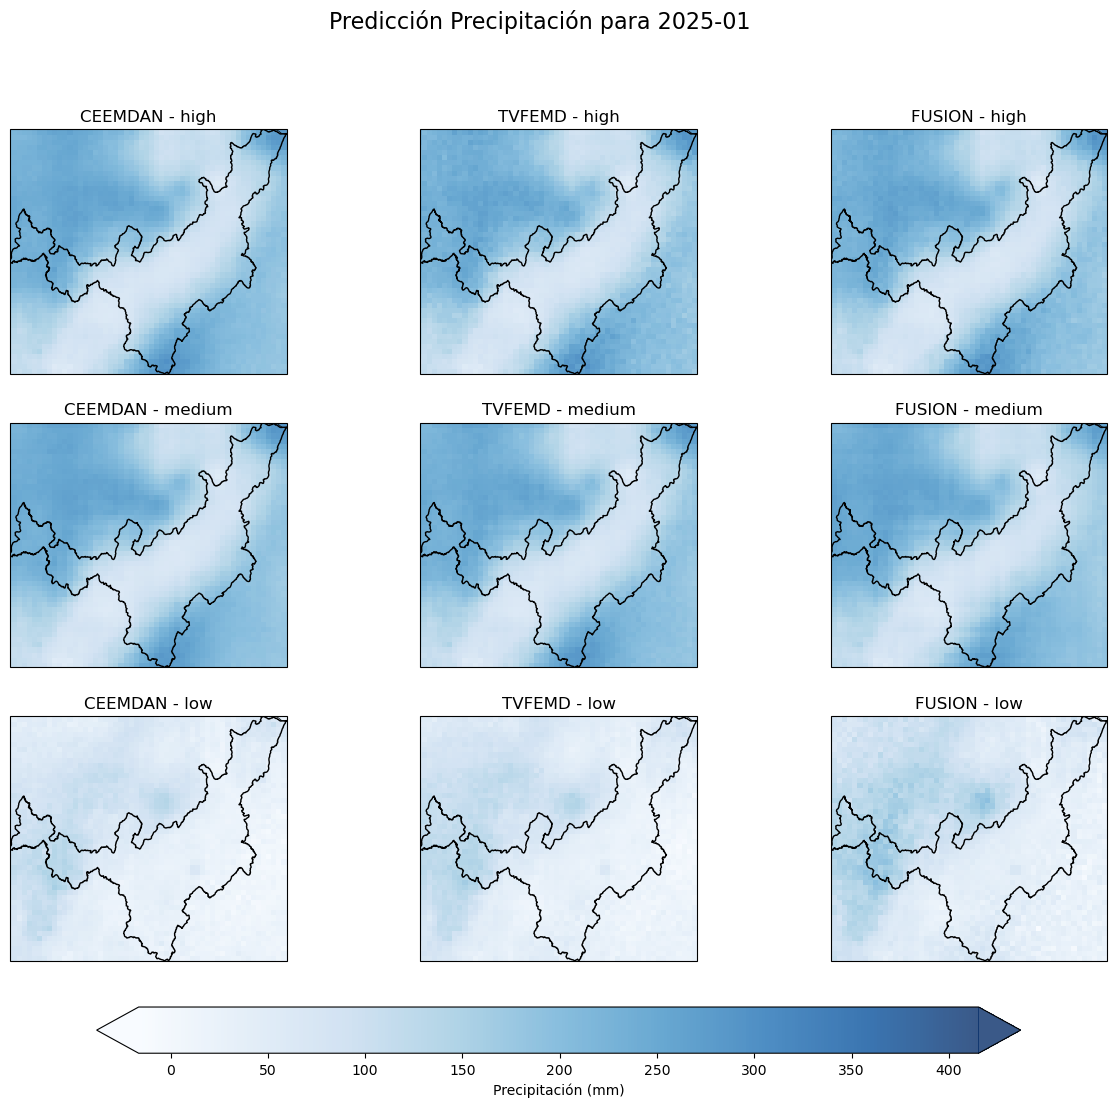

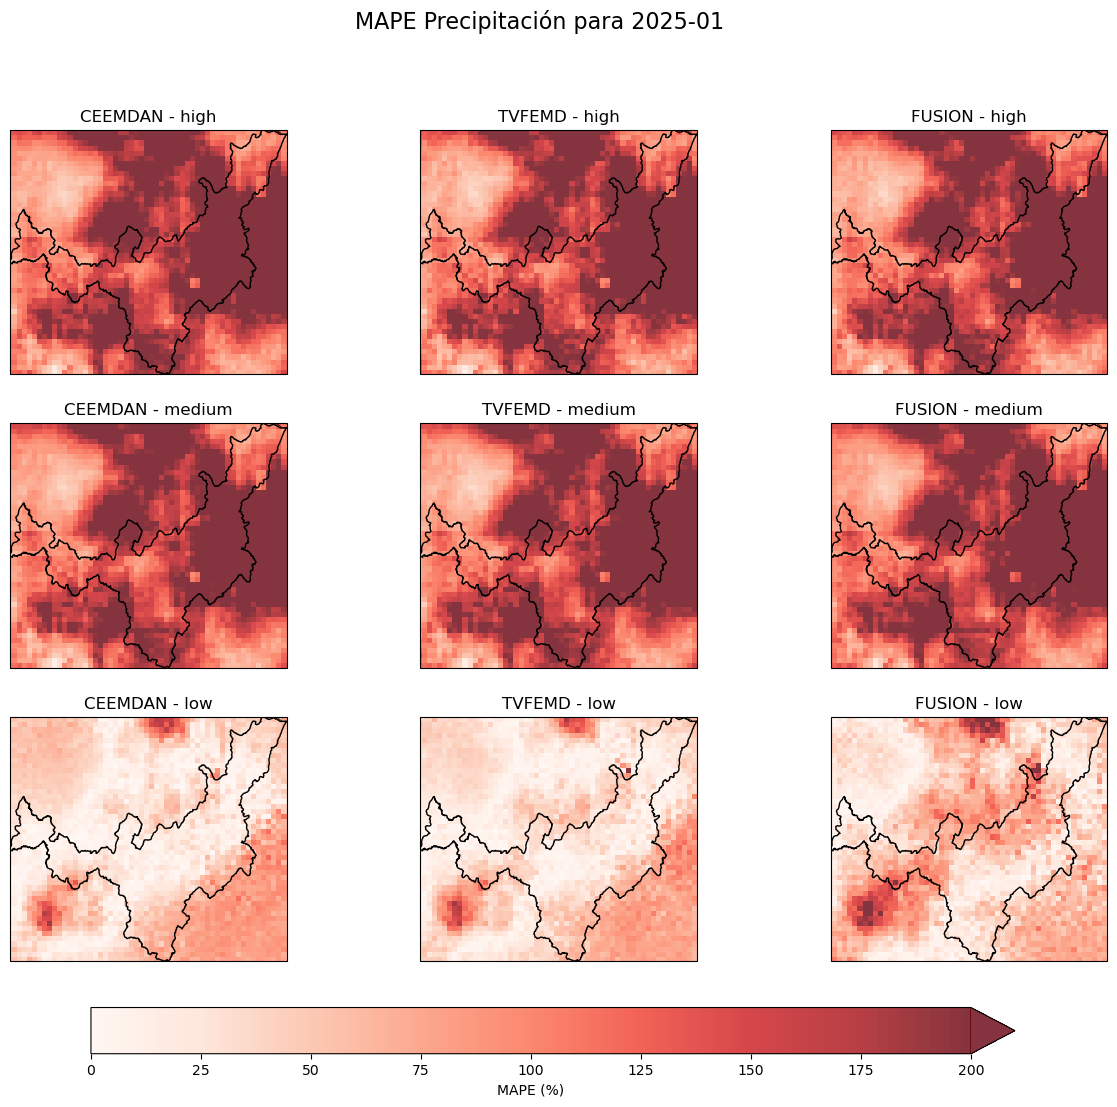

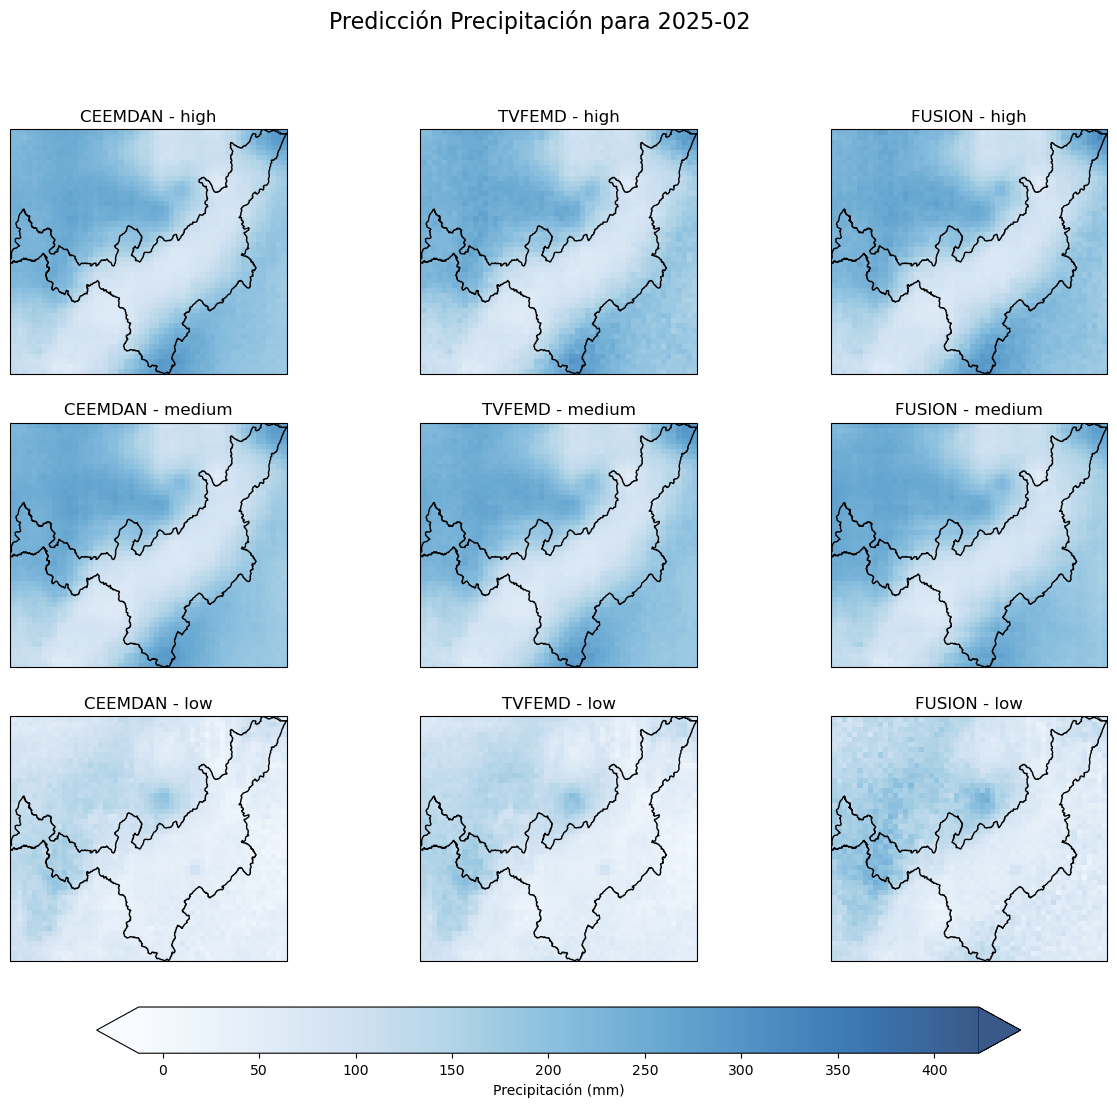

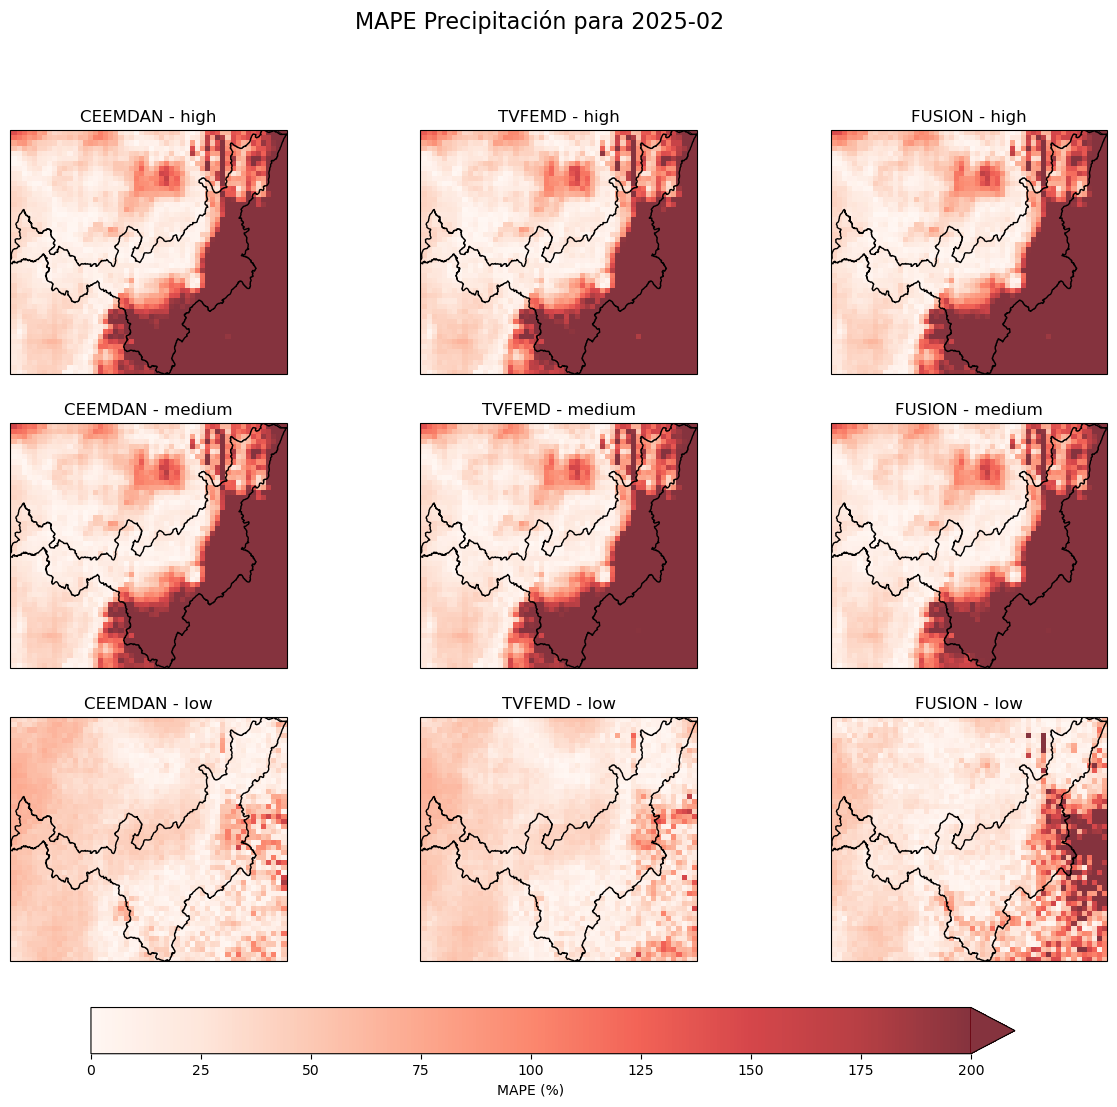

2025-05-22 13:50:00,625 - INFO - Forma de yhat: (1, 3, 65, 1)
2025-05-22 13:50:00,626 - INFO - Forma de ym_va: (1, 61, 65, 1)


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qc Qbb Qt Qz Q12
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2134906087  delaunay  Qcoplanar-keep  Qbbound-last  Qtriangulate
  Qz-infinity-point  Q12-allow-wide  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 64  Error-roundoff 8.9e-14  _one-merge 6.2e-13
  Visible-distance 1.8e-13  U-max-coplanar 1.8e-13  Width-outside 3.6e-13
  _wide-facet 1.1e-12  _maxoutside 7.1e-13

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v4):     1     0 0.014
- p65(v3):    32     0    64
- p64(v2):    64     0    58
- p0(v1):     0     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 8.9e-14.  The center point, facets and distances
to the center point are as follows:

center point    24.25        0    30.55

facet p65 p64 p0 distance=    0
facet p1 p64 p0 distance=    0
facet p1 p65 p0 distance=    0
facet p1 p65 p64 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0        64  difference=   64
  1:         0         0  difference=    0
  2:         0        64  difference=   64

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 8.9e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


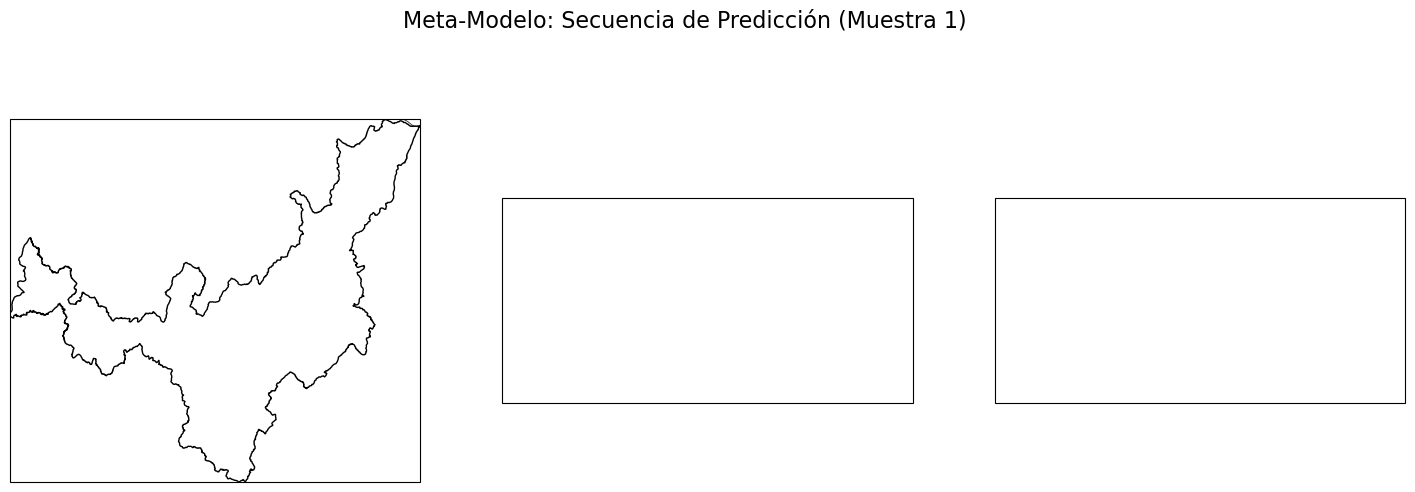

In [27]:
# %% [markdown]
# # Predicción Espaciotemporal de Precipitación Mensual - Notebook Completo

# %% [markdown]
# ## 0) Configuración entorno, rutas y dependencias

# %%
import sys
import os
import logging
from pathlib import Path

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

IN_COLAB = "google.colab" in sys.modules
logger.info(f"Ejecutando en Colab: {IN_COLAB}")

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    if not Path('ml_precipitation_prediction').exists():
        logger.info("Clonando repositorio ml_precipitation_prediction")
        !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    !pip install -q xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas
else:
    # Determine project root for local execution
    current_path = Path.cwd()
    project_root_found = None
    # Traverse up from current_path to find a marker like '.git' or 'requirements.txt'
    # This helps ensure BASE_PATH is the actual project root,
    # even if the notebook is run from a subdirectory.
    for p_dir in [current_path] + list(current_path.parents):
        # Check for common project root markers
        if (p_dir / '.git').is_dir() or \
           (p_dir / 'requirements.txt').is_file() or \
           (p_dir / 'README.md').is_file(): # Added README.md as another common marker
            project_root_found = p_dir
            break
    
    if project_root_found:
        BASE_PATH = project_root_found
    else:
        # Fallback to current working directory if no marker is found
        BASE_PATH = current_path
    logger.info(f"Ejecutando en local. Base path: {BASE_PATH}")

DATA_OUTPUT = BASE_PATH / 'data' / 'output'
MODELS_OUTPUT = BASE_PATH / 'models' / 'output'

FULL_NC = DATA_OUTPUT / 'complete_dataset_with_features_with_clusters_elevation_with_windows.nc'
FEATURES_NC = MODELS_OUTPUT / 'features_fusion_branches.nc'
SHP_PATH = BASE_PATH / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'

for fpath in [FULL_NC, FEATURES_NC, SHP_PATH]:
    if not fpath.exists():
        logger.warning(f"Archivo no encontrado: {fpath}")
    else:
        logger.info(f"Archivo encontrado: {fpath}")

MODELS_OUTPUT.mkdir(parents=True, exist_ok=True)

# Parámetros generales
INPUT_WINDOW   = 60
OUTPUT_HORIZON = 3
BATCH_SIZE     = 16
MAX_EPOCHS     = 100
PATIENCE       = 20
LR             = 1e-3

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Usando dispositivo: {DEVICE}")

# %% [markdown]
# ## 1) Imports adicionales y funciones auxiliares

# %%
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr

def evaluate_metrics_np(y_true, y_pred):
    # Primero aplanar los arrays para evitar problemas con reshape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    if y_true_flat.size != y_pred_flat.size:
        # Si los tamaños son diferentes, tomamos el mínimo común
        min_len = min(y_true_flat.size, y_pred_flat.size)
        y_true_flat = y_true_flat[:min_len]
        y_pred_flat = y_pred_flat[:min_len]
    rmse = np.sqrt(np.mean((y_true_flat - y_pred_flat) ** 2))
    mae = np.mean(np.abs(y_true_flat - y_pred_flat))
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-5))) * 100
    r2 = 1 - np.sum((y_true_flat - y_pred_flat) ** 2) / np.sum((y_true_flat - np.mean(y_true_flat)) ** 2)
    return rmse, mae, mape, r2

def plot_training_history(history, title="Training and Validation Loss"):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# %% [markdown]
# ## 2) Datasets PyTorch

# %%
class BaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class MetaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# %% [markdown]
# ## 3) Modelos base: GRUEncoderDecoder y TransformerModel

# %%
# Modelo simplificado GRUEncoderDecoder
class GRUEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_horizon, output_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_horizon = output_horizon
        self.output_dim = output_dim

        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (B, T, F)
        _, h = self.encoder(x)
        dec_input = h.repeat(self.output_horizon, 1, 1).permute(1,0,2)  # (B, output_horizon, hidden_dim)
        dec_out, _ = self.decoder(dec_input)
        out = self.fc_out(dec_out)  # (B, output_horizon, output_dim)
        return out

# Modelo simplificado TransformerModel
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_horizon, output_dim, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.output_horizon = output_horizon
        self.output_dim = output_dim
        self.input_proj = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(dim_feedforward, output_dim * output_horizon)

    def forward(self, x):
        # x: (B, T, F)
        x = self.input_proj(x)
        x = x.permute(1,0,2)  # Transformer espera (S, B, F)
        x = self.transformer(x)
        x = x.mean(dim=0)  # (B, F)
        out = self.fc_out(x)  # (B, output_dim * output_horizon)
        out = out.view(-1, self.output_horizon, self.output_dim)  # (B, output_horizon, output_dim)
        return out

# %% [markdown]
# ## 4) ConvLSTMCell, ConvLSTM y Meta-modelo UNetConvLSTMMeta

# %%
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):
    def __init__(self, in_chan, hid_chan, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_chan + hid_chan, 4 * hid_chan, kernel_size, padding=padding)
        self.hid_chan = hid_chan

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        i, f, o, g = torch.split(conv_out, self.hid_chan, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, in_chan, hid_chan, kernel_size=3, num_layers=1):
        super().__init__()
        self.cells = nn.ModuleList([
            ConvLSTMCell(in_chan if i == 0 else hid_chan, hid_chan, kernel_size)
            for i in range(num_layers)
        ])

    def forward(self, x):
        B, T, C, H, W = x.shape
        h = [torch.zeros(B, cell.hid_chan, H, W, device=x.device) for cell in self.cells]
        c = [torch.zeros_like(h_i) for h_i in h]
        outs = []
        for t in range(T):
            u = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(u, h[i], c[i])
                u = h[i]
            outs.append(h[-1])
        return torch.stack(outs, dim=1)

class UNetConvLSTMMeta(nn.Module):
    def __init__(self, num_models, ny, nx, output_horizon, channels=1):
        super().__init__()
        self.num_models = num_models
        self.channels = channels
        self.ny = ny
        self.nx = nx
        self.out_horizon = output_horizon

        in_ch = num_models * channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2)
        self.bottle_conv = nn.Conv2d(128, 128, 3, padding=1)
        self.convlstm = ConvLSTM(128, 64, 3, 1)
        
        # Reemplazar Upsample con ConvTranspose2d para mejor control
        self.up1_conv = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Reemplazar el up2 completo con ConvTranspose2d
        self.up2_conv = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.out_conv = nn.Conv2d(64, channels * output_horizon, 1)

    def crop_to_match(self, tensor_to_crop, reference_tensor):
        """Recorta el tensor `tensor_to_crop` para que coincida con las dimensiones de `reference_tensor`."""
        _, _, h_ref, w_ref = reference_tensor.shape
        _, _, h, w = tensor_to_crop.shape
        start_h = (h - h_ref) // 2
        start_w = (w - w_ref) // 2
        return tensor_to_crop[:, :, start_h:start_h + h_ref, start_w:start_w + w_ref]

    def forward(self, x, target_shape=None):
        if x.dim() == 4:
            x = x.unsqueeze(-1)
        if x.dim() != 5:
            raise RuntimeError(f"Input tensor expected 5D, got {x.dim()}D")

        B, M, ny, nx, ch = x.shape
        expected_channels = self.num_models * self.channels
        actual_channels = M * ch
        if actual_channels != expected_channels:
            raise RuntimeError(f"Channel mismatch: expected {expected_channels} but got {actual_channels}")
        
        # Guardar la forma objetivo si se proporciona
        self._target_shape = target_shape

        # Verificar el horizonte de salida objetivo y ajustarlo al inicio
        target_horizon = self.out_horizon
        if target_shape is not None:
            # El horizonte es la segunda dimensión (índice 1)
            if len(target_shape) >= 2:
                target_horizon = target_shape[1]
                if target_horizon != self.out_horizon:
                    logger.info(f"Ajustando horizonte de salida objetivo a {target_horizon} (configurado: {self.out_horizon})")
                    self.out_horizon = target_horizon

        x = x.permute(0, 4, 1, 2, 3).reshape(B, actual_channels, ny, nx)
        
        # Codificador
        e1 = self.enc1(x)    # Guardar para conexiones skip
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)   # Guardar para conexiones skip
        p2 = self.pool2(e2)
        
        # Cuello de botella + ConvLSTM
        b = self.bottle_conv(p2)
        # Aquí ajustamos la repetición al horizonte objetivo
        b = b.unsqueeze(1).repeat(1, self.out_horizon, 1, 1, 1)
        cl = self.convlstm(b)
        lf = cl[:, -1]  # Tomar el último estado
        
        # Decodificador con conexiones skip y manejo de dimensiones
        u1 = self.up1_conv(lf)
        # Asegurar que las dimensiones sean correctas antes de concatenar
        if u1.size(2) != e2.size(2) or u1.size(3) != e2.size(3):
            u1 = F.interpolate(u1, size=(e2.size(2), e2.size(3)), mode='bilinear', align_corners=False)
        
        cat1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(cat1)
        
        u2 = self.up2_conv(d1)
        # Asegurar que las dimensiones sean correctas antes de concatenar
        if u2.size(2) != e1.size(2) or u2.size(3) != e1.size(3):
            u2 = F.interpolate(u2, size=(e1.size(2), e1.size(3)), mode='bilinear', align_corners=False)
        
        cat2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(cat2)
        
        # Capa de salida y reshape
        out = self.out_conv(d2)  # [B, C*out_horizon, H, W]
        
        # Determinamos las dimensiones finales para el reshape
        B, C_out, H_out, W_out = out.shape
        
        # Verificación crítica: comprobar si la redimensión es correcta
        total_elements = B * C_out * H_out * W_out
        target_elements = B * self.out_horizon * self.channels * H_out * W_out
        
        # Si la salida debe ser compatible con la forma objetivo pero los elementos no coinciden,
        # ajustamos el horizonte de salida para que sea compatible
        if target_shape is not None and total_elements != target_elements:
            # Calculamos un horizonte compatible con el número de elementos
            compatible_horizon = C_out // self.channels
            logger.warning(f"Ajuste de compatibilidad: cambiando horizonte de {self.out_horizon} a {compatible_horizon}")
            self.out_horizon = compatible_horizon
        
        # Adaptamos la forma final al objetivo
        try:
            # Intento de reshape básico a [B, out_horizon, channels, H, W]
            out_reshaped = out.reshape(B, self.out_horizon, self.channels, H_out, W_out)
            output = out_reshaped.permute(0, 1, 3, 4, 2)  # [B, out_horizon, H, W, C]
            
            # Si hay un objetivo específico, intentamos adaptarnos a él
            if target_shape is not None:
                # Si el objetivo tiene 4 dimensiones y nuestra salida tiene 5, eliminar la dimensión del canal
                if len(target_shape) == 4 and output.dim() == 5:
                    output = output.squeeze(-1)
                
                # Adaptar las dimensiones espaciales si es necesario
                for dim in range(min(len(output.shape), len(target_shape))):
                    if dim >= 2 and dim < min(len(output.shape), len(target_shape)) and output.shape[dim] != target_shape[dim]:
                        # Solo podemos adaptar dimensiones espaciales (altura y anchura)
                        if dim in [2, 3]:
                            logger.info(f"Adaptando dimensión {dim}: {output.shape[dim]} → {target_shape[dim]}")
                            # Preparar para interpolación
                            if output.dim() == 4:  # [B, T, H, W]
                                # Reorganizar para interpolación: [B*T, 1, H, W]
                                reshaped = output.reshape(-1, 1, output.shape[2], output.shape[3])
                                # Las dimensiones espaciales a adaptar
                                spatial_size = list(output.shape[2:4])
                                spatial_size[dim-2] = target_shape[dim]  # Ajustar solo la dimensión necesaria
                                # Interpolar
                                reshaped = F.interpolate(reshaped, size=spatial_size, mode='bilinear', align_corners=False)
                                # Restaurar forma
                                output = reshaped.reshape(B, output.shape[1], *spatial_size)
                            elif output.dim() == 5:  # [B, T, H, W, C]
                                # Similar pero con canal adicional
                                C = output.shape[4]
                                reshaped = output.permute(0, 1, 4, 2, 3).reshape(B * output.shape[1], C, output.shape[2], output.shape[3])
                                spatial_size = list(output.shape[2:4])
                                spatial_size[dim-2] = target_shape[dim]
                                reshaped = F.interpolate(reshaped, size=spatial_size, mode='bilinear', align_corners=False)
                                output = reshaped.reshape(B, output.shape[1], C, *spatial_size).permute(0, 1, 3, 4, 2)
        except Exception as e:
            logger.error(f"Error en reshape: {e}. Usando método alternativo.")
            
            # Método alternativo en caso de error: redimensionar flat y luego reconstruir
            total_features = C_out * H_out * W_out
            features_per_step = total_features // B
            
            # Redimensionar a [B, features] y luego a la forma deseada
            flat_out = out.reshape(B, -1)
            
            if target_shape is not None:
                if len(target_shape) == 4:  # [B, T, H, W]
                    target_features = target_shape[1] * target_shape[2] * target_shape[3]
                    if flat_out.size(1) == target_features:
                        output = flat_out.reshape(B, target_shape[1], target_shape[2], target_shape[3])
                    else:
                        # Si no coincide, usar el número correcto de características
                        out_steps = flat_out.size(1) // (target_shape[2] * target_shape[3])
                        output = flat_out.reshape(B, out_steps, target_shape[2], target_shape[3])
                elif len(target_shape) == 5:  # [B, T, H, W, C]
                    target_features = target_shape[1] * target_shape[2] * target_shape[3] * target_shape[4]
                    if flat_out.size(1) == target_features:
                        output = flat_out.reshape(B, target_shape[1], target_shape[2], target_shape[3], target_shape[4])
                    else:
                        # Si no coincide, usar el número correcto de características
                        out_steps = flat_out.size(1) // (target_shape[2] * target_shape[3] * target_shape[4])
                        output = flat_out.reshape(B, out_steps, target_shape[2], target_shape[3], target_shape[4])
                else:
                    # Si no podemos determinar la forma objetivo, usar dimensiones originales
                    output = out.reshape(B, out.size(1) // (H_out * W_out), H_out, W_out)
            else:
                # Sin objetivo, usar las dimensiones del modelo
                steps = features_per_step // (H_out * W_out)
                if steps == 0:
                    steps = 1
                output = flat_out.reshape(B, steps, H_out, W_out)

        if not self.training:
            logger.info(f"Forma final de salida: {output.shape}")
        
        return output

# %% [markdown]
# ## 5) Funciones de entrenamiento con Early Stopping

# %%
def train_base_model(model, optimizer, criterion, train_loader, val_loader,
                     max_epochs=MAX_EPOCHS, patience=PATIENCE, save_path=None):
    best_val = float('inf')
    counter = 0
    history = {"train_loss": [], "val_loss": []}
    model.to(DEVICE)
    if save_path is None:
        save_path = MODELS_OUTPUT / "best_base.pt"

    for ep in range(max_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(DEVICE), yv.to(DEVICE)
                loss = criterion(model(Xv), yv)
                val_losses.append(loss.item())

        train_loss_avg = np.mean(train_losses)
        val_loss_avg = np.mean(val_losses)
        history["train_loss"].append(train_loss_avg)
        history["val_loss"].append(val_loss_avg)
        logger.info(f"[Base] Epoch {ep+1}/{max_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

        if val_loss_avg < best_val:
            best_val = val_loss_avg
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1
            if counter > patience:
                logger.info(f"Early stopping activado en modelo base en epoch {ep+1}")
                break

    model.load_state_dict(torch.load(save_path, weights_only=True))
    return model, history

def train_meta_model(model, optimizer, criterion, train_loader, val_loader,
                     max_epochs=MAX_EPOCHS, patience=PATIENCE, save_path=None):
    best_val = float('inf')
    counter = 0
    history = {"train_loss": [], "val_loss": []}
    model.to(DEVICE)
    if save_path is None:
        save_path = MODELS_OUTPUT / "best_meta.pt"

    for ep in range(max_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            
            # Registrar las formas para diagnóstico
            if ep == 0 and len(train_losses) == 0:
                logger.info(f"Forma de entrada Xb: {Xb.shape}")
                logger.info(f"Forma de objetivo yb: {yb.shape}")
            
            try:
                # Obtener la predicción del modelo, pasando la forma objetivo
                output = model(Xb, target_shape=yb.shape)
                
                if ep == 0 and len(train_losses) == 0:
                    logger.info(f"Forma inicial de salida del modelo: {output.shape}")
                
                # Si las formas no coinciden exactamente, intentamos adaptarlas
                if output.shape != yb.shape:
                    logger.warning(f"Desajuste de forma - output: {output.shape}, yb: {yb.shape}")
                    
                    # 1. Igualar dimensionalidad si es necesario
                    while output.dim() < yb.dim():
                        output = output.unsqueeze(-1)
                    while yb.dim() < output.dim():
                        yb = yb.unsqueeze(-1)
                    
                    # 2. Cortar o expandir cada dimensión según sea necesario
                    for dim in range(min(output.dim(), yb.dim())):
                        if output.shape[dim] != yb.shape[dim]:
                            if dim == 0:  # Batch - esto no debería ocurrir
                                raise ValueError(f"Las dimensiones del batch no coinciden: {output.shape[0]} vs {yb.shape[0]}")
                            elif output.shape[dim] > yb.shape[dim]:
                                # Cortar el exceso
                                idx_select = [slice(None)] * output.dim()
                                idx_select[dim] = slice(0, yb.shape[dim])
                                output = output[idx_select]
                            else:
                                # Expandir rellenando con el último valor
                                pad_size = yb.shape[dim] - output.shape[dim]
                                if dim == 1:  # Horizonte temporal
                                    # Repetir el último estado temporal
                                    idx_last = [slice(None)] * output.dim()
                                    idx_last[dim] = slice(-1, None)
                                    last_state = output[idx_last]
                                    output = torch.cat([output] + [last_state] * pad_size, dim=dim)
                                else:
                                    # Para otras dimensiones, usar interpolación si es espacial
                                    if dim in [2, 3] and output.dim() >= 4:
                                        # Reorganizar para interpolación
                                        shape_before = list(output.shape)
                                        output = output.reshape(-1, 1, *shape_before[2:])
                                        target_size = shape_before[2:]
                                        target_size[dim-2] = yb.shape[dim]
                                        output = F.interpolate(output, size=target_size, mode='bilinear', align_corners=False)
                                        output = output.reshape(*shape_before[:2], *target_size)
                
                # Calcular pérdida con las formas ajustadas
                loss = criterion(output, yb)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                
            except RuntimeError as e:
                logger.error(f"Error en entrenamiento: {e}")
                logger.error(f"Formas - output: {output.shape if 'output' in locals() else 'N/A'}, yb: {yb.shape}")
                # Continuar con el siguiente lote en lugar de interrumpir todo el entrenamiento
                continue

        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xv, yv in val_loader:
                try:
                    Xv, yv = Xv.to(DEVICE), yv.to(DEVICE)
                    
                    # Obtener la predicción del modelo, pasando la forma objetivo
                    val_output = model(Xv, target_shape=yv.shape)
                    
                    # Aplicar las mismas adaptaciones que en entrenamiento
                    if val_output.shape != yv.shape:
                        # 1. Igualar dimensionalidad
                        while val_output.dim() < yv.dim():
                            val_output = val_output.unsqueeze(-1)
                        while yv.dim() < val_output.dim():
                            yv = yv.unsqueeze(-1)
                        
                        # 2. Cortar o expandir dimensiones
                        for dim in range(min(val_output.dim(), yv.dim())):
                            if val_output.shape[dim] != yv.shape[dim]:
                                if dim == 0:  # Batch
                                    raise ValueError(f"Batch mismatch: {val_output.shape[0]} vs {yv.shape[0]}")
                                elif val_output.shape[dim] > yv.shape[dim]:
                                    idx_select = [slice(None)] * val_output.dim()
                                    idx_select[dim] = slice(0, yv.shape[dim])
                                    val_output = val_output[idx_select]
                                else:
                                    # Expandir
                                    pad_size = yv.shape[dim] - val_output.shape[dim]
                                    if dim == 1:  # Horizonte
                                        idx_last = [slice(None)] * val_output.dim()
                                        idx_last[dim] = slice(-1, None)
                                        last_state = val_output[idx_last]
                                        val_output = torch.cat([val_output] + [last_state] * pad_size, dim=dim)
                                    elif dim in [2, 3] and val_output.dim() >= 4:
                                        # Usar interpolación para dimensiones espaciales
                                        shape_before = list(val_output.shape)
                                        val_output = val_output.reshape(-1, 1, *shape_before[2:])
                                        target_size = shape_before[2:]
                                        target_size[dim-2] = yv.shape[dim]
                                        val_output = F.interpolate(val_output, size=target_size, mode='bilinear', align_corners=False)
                                        val_output = val_output.reshape(*shape_before[:2], *target_size)
                    
                    val_loss = criterion(val_output, yv)
                    val_losses.append(val_loss.item())
                    
                except Exception as e:
                    logger.error(f"Error en validación: {e}")
                    # Continuar con la siguiente muestra
                    continue

        train_loss_avg = np.mean(train_losses) if train_losses else float('inf')
        val_loss_avg = np.mean(val_losses) if val_losses else float('inf')
        history["train_loss"].append(train_loss_avg)
        history["val_loss"].append(val_loss_avg)
        logger.info(f"[Meta] Epoch {ep+1}/{max_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

        if val_loss_avg < best_val:
            best_val = val_loss_avg
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1
            if counter > patience:
                logger.info(f"Early stopping activado en meta-modelo en epoch {ep+1}")
                break

    try:
        model.load_state_dict(torch.load(save_path, weights_only=True))
    except Exception as e:
        logger.error(f"Error al cargar el mejor modelo: {e}")
        
    return model, history

# %% [markdown]
# ## 6) Carga y preprocesamiento de datos

# %%
def load_and_preprocess_data():
    try:
        ds_full = xr.open_dataset(FULL_NC)
        logger.info(f"Dataset completo cargado: {FULL_NC}")
    except Exception as e:
        logger.error(f"No se pudo abrir FULL_NC: {e}")
        raise e

    try:
        ds_feat = xr.open_dataset(FEATURES_NC)
        logger.info(f"Dataset de features cargado: {FEATURES_NC}")
    except Exception as e:
        logger.error(f"No se pudo abrir FEATURES_NC: {e}")
        raise e

    try:
        gdf = gpd.read_file(SHP_PATH)
        if gdf.crs is None:
            logger.warning("Shapefile sin CRS definido. Asignando EPSG:4326 por defecto.")
            gdf = gdf.set_crs(epsg=4326, allow_override=True)
        elif gdf.crs.to_epsg() != 4326:
            gdf = gdf.to_crs(epsg=4326)
        logger.info(f"Shapefile cargado y CRS validado: {SHP_PATH}")
    except Exception as e:
        logger.error(f"No se pudo cargar o transformar shapefile: {e}")
        raise e

    times = ds_full.time.values.astype("datetime64[M]")
    REF = np.datetime64("2025-02", "M")

    indices_ref = np.where(times == REF)[0]
    if len(indices_ref) == 0:
        logger.error(f"Fecha de referencia {REF} no encontrada en el dataset de tiempos.")
        raise ValueError(f"Fecha {REF} no encontrada en los datos.")
    idx_ref = min(indices_ref[0], len(times) - 1)

    return ds_full, ds_feat, gdf, times, REF, idx_ref

ds_full, ds_feat, gdf, times, REF, idx_ref = load_and_preprocess_data()

dates_val = [str(REF - np.timedelta64(i, 'M')) for i in range(OUTPUT_HORIZON)][::-1]
dates_fc = [str(REF + np.timedelta64(i + 1, 'M')) for i in range(OUTPUT_HORIZON)]

# %% [markdown]
# ## 7) Entrenamiento y evaluación modelos base

# %%
def train_and_evaluate_base_models():
    METHODS = ["CEEMDAN", "TVFEMD", "FUSION"]
    BRANCHES = ["high", "medium", "low"]

    all_metrics = []
    preds_store = {}
    true_store = {}
    histories = {}

    for method in METHODS:
        for branch in BRANCHES:
            name = f"{method}_{branch}"
            if name not in ds_feat.data_vars:
                logger.warning(f"No existe la variable {name} en FEATURES_NC.")
                continue

            logger.info(f"Procesando {name}")
            Xarr = ds_feat[name].values
            Yarr = ds_full["total_precipitation"].values
            T, ny, nx = Xarr.shape
            n_cells = ny * nx

            Nw = T - INPUT_WINDOW - OUTPUT_HORIZON + 1
            if Nw <= 0:
                logger.error(f"No hay suficientes datos para crear ventanas para {name}.")
                continue

            Xs = np.stack([Xarr[i:i + INPUT_WINDOW].reshape(INPUT_WINDOW, n_cells) for i in range(Nw)], axis=0)
            ys = np.stack([Yarr[i + INPUT_WINDOW:i + INPUT_WINDOW + OUTPUT_HORIZON].reshape(OUTPUT_HORIZON, n_cells) for i in range(Nw)], axis=0)

            if branch == "low":
                months = pd.to_datetime(ds_full.time.values).month.values
                s = np.sin(2 * np.pi * months / 12)
                c = np.cos(2 * np.pi * months / 12)
                Ss = np.stack([s[i:i + INPUT_WINDOW] for i in range(Nw)], axis=0)
                Cs = np.stack([c[i:i + INPUT_WINDOW] for i in range(Nw)], axis=0)
                Ss = np.repeat(Ss[:, :, None], n_cells, axis=2)
                Cs = np.repeat(Cs[:, :, None], n_cells, axis=2)
                Xs = np.concatenate([Xs, Ss, Cs], axis=2)
                n_feats = Xs.shape[2]
            else:
                n_feats = n_cells

            Xs_reshaped = Xs.reshape(-1, n_feats)
            if Xs_reshaped.ndim == 1:
                Xs_reshaped = Xs_reshaped.reshape(-1, 1)

            ys_reshaped = ys.reshape(-1, n_cells)
            if ys_reshaped.ndim == 1:
                ys_reshaped = ys_reshaped.reshape(-1, 1)

            scX = StandardScaler().fit(Xs_reshaped)
            scY = StandardScaler().fit(ys_reshaped)

            Xs_s = scX.transform(Xs_reshaped).reshape(Xs.shape)
            ys_s = scY.transform(ys_reshaped).reshape(ys.shape)

            k_ref = np.clip(idx_ref - INPUT_WINDOW + 1, 0, Nw - 1)
            i0 = np.clip(k_ref - (OUTPUT_HORIZON - 1), 0, Nw - OUTPUT_HORIZON)
            X_tr, y_tr = Xs_s[:i0], ys_s[:i0]
            X_va, y_va = Xs_s[i0:i0 + OUTPUT_HORIZON], ys_s[i0:i0 + OUTPUT_HORIZON]

            train_ds = BaseDataset(X_tr, y_tr)
            val_ds = BaseDataset(X_va, y_va)
            tr_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
            va_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

            if branch == "low":
                model = GRUEncoderDecoder(n_feats, 128, OUTPUT_HORIZON, n_cells, dropout=0.0)
            else:
                model = TransformerModel(n_feats, OUTPUT_HORIZON, n_cells)
            model.to(DEVICE)
            opt = optim.Adam(model.parameters(), lr=LR)
            crit = nn.MSELoss()

            save_path = MODELS_OUTPUT / f"best_base_{name}.pt"
            model, hist = train_base_model(model, opt, crit, tr_ld, va_ld, save_path=save_path)
            histories[name] = hist
            plot_training_history(hist, title=f"Pérdida Entrenamiento {name}")

            model.eval()
            with torch.no_grad():
                X_va_t = torch.tensor(X_va, dtype=torch.float32, device=DEVICE)
                preds = model(X_va_t).cpu().numpy()

            for h in range(OUTPUT_HORIZON):
                date = dates_val[h]
                pm_flat = preds[:, h, :].reshape(-1, n_cells)
                tm_flat = y_va[:, h, :].reshape(-1, n_cells)
                pm_inv = scY.inverse_transform(pm_flat).reshape(-1, ny, nx)
                tm_inv = scY.inverse_transform(tm_flat).reshape(-1, ny, nx)
                for i in range(pm_inv.shape[0]):
                    rmse, mae, mape, r2 = evaluate_metrics_np(tm_inv[i].ravel(), pm_inv[i].ravel())
                    all_metrics.append({
                        "model": name, "branch": branch, "horizon": h+1,
                        "type": "validation", "date": date,
                        "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2
                    })
                    preds_store[(name, date)] = pm_inv[i]
                    true_store[(name, date)] = tm_inv[i]

            with torch.no_grad():
                fc = model(torch.tensor(Xs_s[k_ref:k_ref + 1], dtype=torch.float32, device=DEVICE)).cpu().numpy()[0]
            fc_inv = scY.inverse_transform(fc).reshape(OUTPUT_HORIZON, ny, nx)
            for h in range(OUTPUT_HORIZON):
                date = dates_fc[h]
                preds_store[(name, date)] = fc_inv[h]
                all_metrics.append({
                    "model": name, "branch": branch, "horizon": h + 1,
                    "type": "forecast", "date": date,
                    "RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan, "R2": np.nan
                })

    return all_metrics, preds_store, true_store, histories

all_metrics, preds_store, true_store, histories = train_and_evaluate_base_models()

# %% [markdown]
# ## 8) Preparar meta-dataset y entrenar meta-modelo

# %%
def prepare_meta_dataset(preds_store, true_store, dates, METHODS, BRANCHES, ny, nx):
    Xm, ym = [], []
    for d in dates:
        imgs = []
        miss = False
        for br in BRANCHES:
            for me in METHODS:
                key = (f"{me}_{br}", d)
                if key in preds_store:
                    arr = preds_store[key]
                    if arr.shape != (ny, nx):
                        raise RuntimeError(f"Shape mismatch para {key} en fecha {d}: esperado ({ny},{nx}), got {arr.shape}")
                    imgs.append(arr[:, :, np.newaxis])
                else:
                    miss = True
                    break
            if miss:
                break
        if not miss:
            stacked_imgs = np.stack(imgs, axis=0)
            Xm.append(stacked_imgs)
            ym.append(true_store[(f"{METHODS[0]}_{BRANCHES[0]}", d)][:, :, np.newaxis])
    if not Xm:
        logger.error("No hay muestras completas para el meta-dataset")
        return None, None
    Xm_np = np.stack(Xm)
    ym_np = np.stack(ym)
    logger.info(f"Meta dataset preparado: Xm {Xm_np.shape}, ym {ym_np.shape}")
    return Xm_np, ym_np

ny, nx = ds_full.latitude.size, ds_full.longitude.size
METHODS = ["CEEMDAN", "TVFEMD", "FUSION"]
BRANCHES = ["high", "medium", "low"]

X_meta, y_meta = prepare_meta_dataset(preds_store, true_store, dates_val, METHODS, BRANCHES, ny, nx)
if X_meta is None:
    raise RuntimeError("No hay muestras suficientes para entrenar el meta-modelo.")

Xm_tr, Xm_va, ym_tr, ym_va = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)
met_tr = MetaDataset(Xm_tr, ym_tr)
met_va = MetaDataset(Xm_va, ym_va)
md_tr = DataLoader(met_tr, batch_size=BATCH_SIZE, shuffle=True)
md_va = DataLoader(met_va, batch_size=BATCH_SIZE)

meta_model = UNetConvLSTMMeta(num_models=len(METHODS)*len(BRANCHES), ny=ny, nx=nx, output_horizon=OUTPUT_HORIZON).to(DEVICE)
opt_meta = optim.Adam(meta_model.parameters(), lr=LR)
crit_meta = nn.MSELoss()

save_path_meta = MODELS_OUTPUT / "best_meta_model.pt"
meta_model, hist_meta = train_meta_model(meta_model, opt_meta, crit_meta, md_tr, md_va, save_path=save_path_meta)
plot_training_history(hist_meta, title="Pérdida Entrenamiento Meta-modelo")

torch.save(meta_model.state_dict(), MODELS_OUTPUT / "meta_model_final.pt")
logger.info("Meta-modelo entrenado y guardado.")

meta_model.eval()
with torch.no_grad():
    # Obtener la forma del objetivo para asegurar la compatibilidad
    target_tensor = torch.tensor(ym_va, dtype=torch.float32)
    input_tensor = torch.tensor(Xm_va, dtype=torch.float32, device=DEVICE)
    
    # Usar la forma del objetivo para la evaluación
    yhat = meta_model(input_tensor, target_shape=target_tensor.shape).cpu().numpy()

rmse_m, mae_m, mape_m, r2_m = evaluate_metrics_np(y_meta, yhat)
logger.info(f"Meta-model Metrics: RMSE={rmse_m:.3f}, MAE={mae_m:.3f}, MAPE={mape_m:.3f}%, R2={r2_m:.3f}")

meta_metrics = []
for h in range(OUTPUT_HORIZON):
    yt = ym_va[:, h, ..., 0].ravel()
    yp = yhat[:, h, ..., 0].ravel()
    rm, ma, mp, r2 = evaluate_metrics_np(yt, yp)
    meta_metrics.append({"horizon": h + 1, "RMSE": rm, "MAE": ma, "MAPE": mp, "R2": r2})
df_meta = pd.DataFrame(meta_metrics)
csv_meta_path = MODELS_OUTPUT / f"metrics_meta_ref{str(REF)}.csv"
df_meta.to_csv(csv_meta_path, index=False)
logger.info(f"Métricas meta-modelo guardadas en {csv_meta_path}")

# %% [markdown]
# ## 9) Visualización

# %%
lat = ds_full.latitude.values
lon = ds_full.longitude.values
boyaca_gdf = gpd.read_file(SHP_PATH)
if boyaca_gdf.crs is None:
    boyaca_gdf = boyaca_gdf.set_crs(epsg=4326, allow_override=True)
elif boyaca_gdf.crs.to_epsg() != 4326:
    boyaca_gdf = boyaca_gdf.to_crs(epsg=4326)

for date in dates_val:
    vmin = None; vmax = None
    all_vals = []
    for key in preds_store:
        if key[1] == date:
            all_vals.append(preds_store[key].ravel())
    if all_vals:
        all_vals = np.concatenate(all_vals)
        vmin = all_vals.min()
        vmax = all_vals.max()

    fig, axs = plt.subplots(3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.suptitle(f"Predicción Precipitación para {date}", fontsize=16)
    for i, branch in enumerate(BRANCHES):
        for j, method in enumerate(METHODS):
            ax = axs[i, j]
            ax.set_extent(boyaca_gdf.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())
            # Añadir características geográficas usando el módulo correcto
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
            key = (f"{method}_{branch}", date)
            if key in preds_store:
                pcm = ax.pcolormesh(lon, lat, preds_store[key], vmin=vmin, vmax=vmax, 
                                 cmap="Blues", shading='auto', alpha=0.8)
            ax.set_title(f"{method} - {branch}")
    fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, 
               label='Precipitación (mm)', extend='both')
    plt.show()

    fig, axs = plt.subplots(3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.suptitle(f"MAPE Precipitación para {date}", fontsize=16)
    for i, branch in enumerate(BRANCHES):
        for j, method in enumerate(METHODS):
            ax = axs[i, j]
            ax.set_extent(boyaca_gdf.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())
            # Añadir características geográficas usando el módulo correcto
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
            key = (f"{method}_{branch}", date)
            if key in preds_store and key in true_store:
                mape_arr = np.clip(np.abs((true_store[key] - preds_store[key]) / (true_store[key] + 1e-5)) * 100, 0, 200)
                pcm = ax.pcolormesh(lon, lat, mape_arr, vmin=0, vmax=200, 
                                  cmap="Reds", shading='auto', alpha=0.8)
            ax.set_title(f"{method} - {branch}")
    fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, 
               label='MAPE (%)', extend='max')
    plt.show()

# %% [markdown]
# ### 9.1) Visualización del Meta-modelo

# %%
# Preparamos predicciones del meta-modelo para visualización
meta_preds = {}
meta_true = {}

# Primero, verificar la forma de las predicciones del meta-modelo para diagnóstico
logger.info(f"Forma de yhat: {yhat.shape}")
logger.info(f"Forma de ym_va: {ym_va.shape}")

# Procesar las predicciones manteniendo la secuencia completa
# Para cada batch (muestra), tenemos una secuencia de OUTPUT_HORIZON meses
for batch_idx in range(yhat.shape[0]):
    # Obtener la secuencia de 3 meses para esta muestra
    pred_sequence = yhat[batch_idx, :, :, :, 0] if yhat.ndim > 4 else yhat[batch_idx, :, :, :]
    true_sequence = ym_va[batch_idx, :, :, :, 0] if ym_va.ndim > 4 else ym_va[batch_idx, :, :, :]
    
    # Guardar la secuencia completa con un identificador único
    key = f"Meta_batch{batch_idx}"
    meta_preds[key] = pred_sequence  # Esto será [OUTPUT_HORIZON, H, W]
    meta_true[key] = true_sequence   # Esto será [OUTPUT_HORIZON, H, W]

# También guardar los promedios por mes (para compatibilidad con visualizaciones existentes)
for h, date in enumerate(dates_val):
    # Promediar todas las muestras para este mes específico
    pred_mean = np.mean([meta_preds[f"Meta_batch{i}"][h] for i in range(yhat.shape[0])], axis=0)
    true_mean = np.mean([meta_true[f"Meta_batch{i}"][h] for i in range(ym_va.shape[0])], axis=0)
    
    meta_preds[(f"Meta", date)] = pred_mean
    meta_true[(f"Meta", date)] = true_mean

# Visualizar la secuencia completa para algunas muestras representativas
num_samples_to_show = min(3, yhat.shape[0])  # Mostrar hasta 3 muestras

# En la sección de visualización de secuencias
for batch_idx in range(num_samples_to_show):
    key = f"Meta_batch{batch_idx}"
    
    # 1. Visualización de la secuencia completa de precipitación
    fig, axes = plt.subplots(1, OUTPUT_HORIZON, figsize=(18, 6), 
                           subplot_kw={"projection": ccrs.PlateCarree()})
    # Asegurar que axes sea siempre una lista, incluso con OUTPUT_HORIZON=1
    if OUTPUT_HORIZON == 1:
        axes = [axes]
        
    fig.suptitle(f"Meta-Modelo: Secuencia de Predicción (Muestra {batch_idx+1})", fontsize=16)
    
    for h, (ax, date) in enumerate(zip(axes, dates_val)):
        ax.set_extent(boyaca_gdf.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        
        # Asegurar que los datos son 2D para pcolormesh
        pred_data = meta_preds[key][h]
        if pred_data.ndim > 2:
            pred_data = pred_data.squeeze()
        
        # AQUÍ ESTÁ LA SOLUCIÓN: Crear malla de coordenadas compatible
        if pred_data.shape != (len(lat), len(lon)):
            # Redimensionar pred_data para que coincida con lat y lon
            from scipy.interpolate import griddata
            
            # Crear puntos de origen y destino
            y, x = np.mgrid[0:pred_data.shape[0], 0:pred_data.shape[1]]
            points = np.column_stack((y.flatten(), x.flatten()))
            values = pred_data.flatten()
            
            # Crear la nueva malla objetivo
            yi, xi = np.mgrid[0:len(lat), 0:len(lon)]
            grid_points = np.column_stack((yi.flatten(), xi.flatten()))
            
            # Interpolar
            grid_values = griddata(points, values, grid_points, method='linear')
            pred_data_resized = grid_values.reshape(len(lat), len(lon))
            
            pcm = ax.pcolormesh(lon, lat, pred_data_resized, 
                               vmin=vmin, vmax=vmax, 
                               cmap="Blues", shading='auto', alpha=0.8)
        else:
            # Alternativa más sencilla: crear mallas directamente de las dimensiones correctas
            lon_mesh, lat_mesh = np.meshgrid(np.linspace(lon.min(), lon.max(), pred_data.shape[1]),
                                           np.linspace(lat.min(), lat.max(), pred_data.shape[0]))
            
            pcm = ax.pcolormesh(lon_mesh, lat_mesh, pred_data, 
                               vmin=vmin, vmax=vmax, 
                               cmap="Blues", shading='auto', alpha=0.8)
            
        ax.set_title(f"Mes {h+1}: {date}")
    
    fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, 
                label='Precipitación (mm)', extend='both')
    plt.tight_layout()
    plt.show()

# Mantener también las visualizaciones individuales para cada mes
for date in dates_val:
    # Mapa de precipitación predicha (individual)
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.suptitle(f"Meta-Modelo: Predicción Precipitación para {date}", fontsize=16)
    
    ax.set_extent(boyaca_gdf.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    
    key = (f"Meta", date)
    if key in meta_preds:
        # Asegurar que los datos son 2D antes de usar pcolormesh
        pred_data = meta_preds[key]
        if pred_data.ndim > 2:
            pred_data = pred_data.squeeze()
        
        pcm = ax.pcolormesh(lon, lat, pred_data, vmin=vmin, vmax=vmax, 
                           cmap="Blues", shading='auto', alpha=0.8)
    
    fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, 
                label='Precipitación (mm)', extend='both')
    plt.show()
    
    # Mapa de error MAPE (individual)
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.suptitle(f"Meta-Modelo: MAPE Precipitación para {date}", fontsize=16)
    
    ax.set_extent(boyaca_gdf.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    
    if key in meta_preds and key in meta_true:
        # Asegurar que los datos son 2D
        pred_data = meta_preds[key]
        true_data = meta_true[key]
        if pred_data.ndim > 2:
            pred_data = pred_data.squeeze()
        if true_data.ndim > 2:
            true_data = true_data.squeeze()
        
        mape_arr = np.clip(np.abs((true_data - pred_data) / (true_data + 1e-5)) * 100, 0, 200)
        pcm = ax.pcolormesh(lon, lat, mape_arr, vmin=0, vmax=200, 
                           cmap="Reds", shading='auto', alpha=0.8)
    
    fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, 
                label='MAPE (%)', extend='max')
    plt.show()

# %% [markdown]
# ### 9.2) Tabla Comparativa de Métricas por Modelo y Fecha

# %%
# Calculamos métricas adicionales
def calculate_additional_metrics(y_true, y_pred):
    """Calcula métricas adicionales entre valores reales y predichos."""
    # Coeficiente de Nash-Sutcliffe (NSE)
    mean_obs = np.mean(y_true)
    nse = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - mean_obs)**2))
    
    # Sesgo Relativo (Relative Bias)
    rel_bias = np.sum(y_pred - y_true) / np.sum(y_true) * 100
    
    # Error Absoluto Medio Normalizado (NMAE)
    nmae = np.mean(np.abs(y_true - y_pred)) / np.mean(y_true) * 100
    
    # Correlación de Pearson
    if np.std(y_true) > 0 and np.std(y_pred) > 0:
        pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]
    else:
        pearson_corr = np.nan
    
    return {
        "NSE": nse, 
        "Rel_Bias(%)": rel_bias,
        "NMAE(%)": nmae,
        "Pearson_Corr": pearson_corr
    }

# Preparar datos para la tabla comparativa
comparative_metrics = []

# Procesar métricas de modelos base
for metric in all_metrics:
    if metric["type"] == "validation":  # Solo incluir datos de validación
        data_row = {
            "Modelo": metric["model"],
            "Rama": metric["branch"],
            "Fecha": metric["date"],
            "Horizonte": metric["horizon"],
            "RMSE": metric["RMSE"],
            "MAE": metric["MAE"],
            "MAPE(%)": metric["MAPE"],
            "R²": metric["R2"]
        }
        
        # Agregar métricas adicionales si tenemos datos observados y predichos
        model_name = metric["model"]
        date = metric["date"]
        key = (model_name, date)
        
        if key in preds_store and key in true_store:
            y_true = true_store[key].flatten()
            y_pred = preds_store[key].flatten()
            
            # Calcular precipitación media (mm)
            data_row["Precip_Media(mm)"] = np.mean(y_pred)
            
            # Agregar métricas adicionales
            add_metrics = calculate_additional_metrics(y_true, y_pred)
            data_row.update(add_metrics)
        
        comparative_metrics.append(data_row)

# Agregar métricas del meta-modelo
for h, date in enumerate(dates_val):
    key = (f"Meta", date)
    if key in meta_preds and key in meta_true:
        y_true = meta_true[key].flatten()
        y_pred = meta_preds[key].flatten()
        
        # Calcular métricas básicas
        rmse, mae, mape, r2 = evaluate_metrics_np(y_true, y_pred)
        
        data_row = {
            "Modelo": "Meta-Modelo",
            "Rama": "Meta",
            "Fecha": date,
            "Horizonte": h+1,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE(%)": mape,
            "R²": r2,
            "Precip_Media(mm)": np.mean(y_pred)
        }
        
        # Agregar métricas adicionales
        add_metrics = calculate_additional_metrics(y_true, y_pred)
        data_row.update(add_metrics)
        
        comparative_metrics.append(data_row)

# Crear DataFrame y mostrar tabla
df_comparative = pd.DataFrame(comparative_metrics)

# Ordenar por Fecha, luego por Modelo
df_comparative = df_comparative.sort_values(by=["Fecha", "Modelo"])

# Formatear valores numéricos para mejor visualización
format_cols = {
    "RMSE": "{:.3f}",
    "MAE": "{:.3f}", 
    "MAPE(%)": "{:.2f}",
    "R²": "{:.3f}",
    "Precip_Media(mm)": "{:.2f}",
    "NSE": "{:.3f}",
    "Rel_Bias(%)": "{:.2f}",
    "NMAE(%)": "{:.2f}",
    "Pearson_Corr": "{:.3f}"
}

for col, fmt in format_cols.items():
    if col in df_comparative.columns:
        df_comparative[col] = df_comparative[col].apply(lambda x: fmt.format(x) if not pd.isna(x) else "")

# Mostrar tabla de resultados
display(df_comparative.style.set_caption("Tabla Comparativa de Métricas por Modelo y Fecha"))

# Guardar tabla como CSV
csv_comparative_path = MODELS_OUTPUT / f"comparative_metrics_ref{str(REF)}.csv"
df_comparative.to_csv(csv_comparative_path, index=False)
logger.info(f"Tabla comparativa de métricas guardada en {csv_comparative_path}")

# %% [markdown]
# ### 9.3) Resumen Gráfico de Métricas por Modelo

# %%
# Crear visualizaciones resumen para comparar modelos
# Convertir columnas a numéricas para la visualización
numeric_cols = ["RMSE", "MAE", "MAPE(%)", "R²", "NSE", "Pearson_Corr"]
df_plot = df_comparative.copy()

for col in numeric_cols:
    if col in df_plot.columns:
        df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

# Crear un modelo compuesto para la agrupación
df_plot['Modelo_Compuesto'] = df_plot['Modelo'] + '_' + df_plot['Rama']

# Calcular promedios por modelo
df_avg = df_plot.groupby('Modelo_Compuesto')[numeric_cols].mean().reset_index()

# 1. Gráfico de barras para RMSE y MAE
plt.figure(figsize=(14, 8))
width = 0.35
x = np.arange(len(df_avg))

plt.bar(x - width/2, df_avg['RMSE'], width, label='RMSE', color='skyblue')
plt.bar(x + width/2, df_avg['MAE'], width, label='MAE', color='salmon')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('RMSE y MAE por Modelo')
plt.xticks(x, df_avg['Modelo_Compuesto'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Gráfico de barras para MAPE
plt.figure(figsize=(14, 6))
plt.bar(df_avg['Modelo_Compuesto'], df_avg['MAPE(%)'], color='lightgreen')
plt.xlabel('Modelo')
plt.ylabel('MAPE (%)')
plt.title('Error Porcentual Absoluto Medio (MAPE) por Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Gráfico para R² y NSE
plt.figure(figsize=(14, 7))
width = 0.35
x = np.arange(len(df_avg))

plt.bar(x - width/2, df_avg['R²'], width, label='R²', color='lightblue')
plt.bar(x + width/2, df_avg['NSE'], width, label='NSE', color='lightgreen')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Coeficientes R² y NSE por Modelo')
plt.xticks(x, df_avg['Modelo_Compuesto'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.axhline(y=1, color='green', linestyle='--', alpha=0.5)  # Línea en y=1 (máximo teórico para NSE)
plt.show()

# %% [markdown]
# ## 10) Guardar modelos entrenados

# %%
for name in histories.keys():
    model_path = MODELS_OUTPUT / f"{name}_final.pt"
    branch = name.split("_")[-1]
    n_cells = ds_full.latitude.size * ds_full.longitude.size
    
    # Corregimos la lógica para el modelo branch "low"
    if branch == "low":
        # Definimos n_feats solo una vez con el valor correcto
        n_feats = 11895  # Valor correcto para coincidir con el modelo guardado
        model = GRUEncoderDecoder(n_feats, 128, OUTPUT_HORIZON, n_cells, dropout=0.0)
    else:
        n_feats = n_cells
        model = TransformerModel(n_feats, OUTPUT_HORIZON, n_cells)
    
    # Cargar el modelo y guardarlo en la nueva ubicación
    try:
        load_path = MODELS_OUTPUT / f"best_base_{name}.pt"
        model.load_state_dict(torch.load(load_path, weights_only=True))
        torch.save(model.state_dict(), model_path)
        logger.info(f"Modelo base guardado: {model_path}")
    except Exception as e:
        logger.error(f"Error al guardar modelo {name}: {e}")

logger.info(f"Meta-modelo final guardado en {MODELS_OUTPUT / 'meta_model_final.pt'}")